In [1]:
import os
import torch
import numpy as np
from pprint import pprint
from dataclasses import dataclass, asdict
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

import torch.nn.functional as F

from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig,BasicPipelineConfig
from conditional_rate_matching.data.states_dataloaders_config import StatesDataloaderConfig
from conditional_rate_matching.data.dataloaders_utils import get_dataloaders_crm
from conditional_rate_matching.models.trainers.call_all_trainers import call_trainer

from conditional_rate_matching.configs.config_files import ExperimentFiles

from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig
from conditional_rate_matching.configs.configs_classes.config_crm import CRMTrainerConfig
from conditional_rate_matching.configs.configs_classes.config_crm import OptimalTransportSamplerConfig

from conditional_rate_matching.models.trainers.crm_trainer import CRMTrainer
from conditional_rate_matching.utils.histograms import (
    categorical_histogram_dataloader,
    categorical_counts_per_path,
    get_conditional_histograms_paths,
    plot_time_series_histograms
)
from conditional_rate_matching.models.trainers.crm_trainer import CRMDataloder
from conditional_rate_matching.models.pipelines.thermostat.crm_thermostat_config import ConstantThermostatConfig,LogThermostatConfig


/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/tqdm-4.66.1-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
config = CRMConfig()
device = 'cpu'
vocab_size = 6
dimensions = 2
gamma=1./vocab_size
config.data0 = StatesDataloaderConfig(dimensions=1,vocab_size=vocab_size)
config.data1 = StatesDataloaderConfig(dirichlet_alpha=0.025,
                                      total_data_size=500,
                                      dimensions=dimensions,
                                      vocab_size=vocab_size,
                                      test_size=0.1)

config.pipeline = BasicPipelineConfig(number_of_steps=100)
config.thermostat = ConstantThermostatConfig(gamma=gamma)
config.trainer = CRMTrainerConfig(number_of_epochs=100,learning_rate=1e-3, device=device)
config.optimal_transport = OptimalTransportSamplerConfig(name="uniform",cost="log")

crm = CRM(config=config)

# Train Model

In [4]:
experiment_files = ExperimentFiles(experiment_name="crm",
                                   experiment_type="tutorial",
                                   experiment_indentifier=None)
crm_trainer = CRMTrainer(config, experiment_files) # TRAINER CREATES MODEL FROM CONFIG FILE
results_, all_metrics = crm_trainer.train()

# ==================================================
# START OF TRAINING 
# ==================================================
# Current Model ************************************
tutorial
crm
None
# ==================================================
# Number of Epochs 100
# ==================================================


Epoch 100, Loss: 0.0011: 100%|██████████| 100/100 [00:13<00:00,  7.62it/s]


In [5]:
crm = CRM(experiment_dir=experiment_files.experiment_dir)
crm.config.pipeline.number_of_steps = 200
sample_x = crm.pipeline(sample_size=10,train=False)


0it [00:00, ?it/s]

200it [00:01, 174.55it/s]


In [8]:
# dimensions = config.data1.dimensions
# vocab_size = config.data1.vocab_size

x_f, x_path, t_path = crm.pipeline(sample_size=500,return_path=True)
histogram_0 = categorical_histogram_dataloader(crm.dataloader_0,dimensions=dimensions,number_of_classes=vocab_size)
histogram_1 = categorical_histogram_dataloader(crm.dataloader_1,dimensions=dimensions,number_of_classes=vocab_size)
histograms_paths = categorical_counts_per_path(x_path.cpu(),dimensions=3,vocab_size=vocab_size,normalize=True)
conditional_histograms_paths = get_conditional_histograms_paths(crm,t_path.cpu(),num_timesteps_to_plot=10)

200it [00:01, 170.26it/s]
200it [00:01, 167.92it/s]
200it [00:01, 168.15it/s]
200it [00:00, 206.97it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

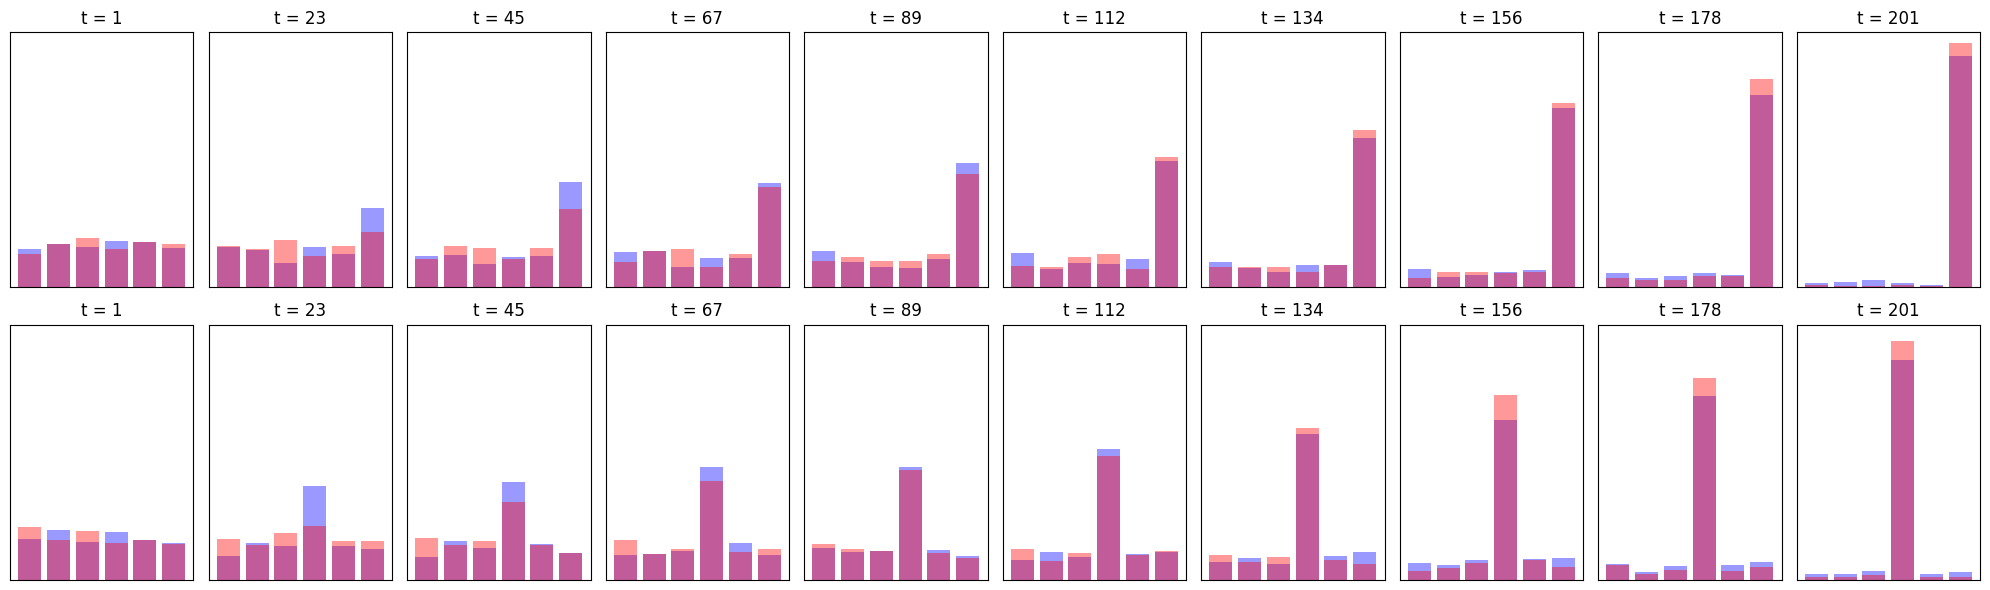

In [7]:
indices = plot_time_series_histograms(histograms_paths, conditional_histograms_paths, 10)

In [9]:
databatch0 = next(crm.dataloader_0.train().__iter__())
databatch1 = next(crm.dataloader_1.train().__iter__())

In [11]:
crm.sample_pair(databatch0,databatch1,torch.device("cpu"))

(tensor([[2., 1.],
         [2., 2.],
         [4., 2.],
         [5., 1.],
         [1., 1.],
         [3., 1.],
         [2., 3.],
         [1., 2.],
         [2., 5.],
         [2., 2.],
         [5., 4.],
         [4., 1.],
         [5., 3.],
         [2., 0.],
         [0., 1.],
         [0., 0.],
         [3., 2.],
         [3., 2.],
         [0., 0.],
         [3., 3.],
         [2., 2.],
         [1., 5.],
         [2., 2.]]),
 tensor([[5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.],
         [5., 3.]]))

# Calculate Metrics Again

In [ ]:
from conditional_rate_matching.models.metrics.metrics_utils import log_metrics, MetricsAvaliable
metrics_avaliable = MetricsAvaliable()

In [ ]:
# number of samples requiered to calculate the test 
# this number should not be that big as the sample and paths are stored to perform the statistics
crm.config.trainer.max_test_size = crm.config.data1.test_size 
crm.config.pipeline.number_of_steps = 100
crm.config.data1.test_size 

In [ ]:
metric_string = metrics_avaliable.mse_histograms
test_statistics = []
for i in range(10):
    metrics = log_metrics(crm,all_metrics={},metrics_to_log={metric_string})
    print(metrics)
    test_statistics.append(metrics["mse_marginal_histograms"])
test_statistics = np.asarray(test_statistics)